In [6]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy import stats

## Setup: Import the Datasets
Dataset on Happiness Index: Attached file <mark>"HappinessCantrilLadder2005-2020.csv"</mark><br/>
Dataset on Internet Users: Attached file <mark>"CO2Emissions.csv"</mark>.

In [7]:
df = pd.read_csv('HappinessCantrilLadder2005-2020.csv')
df.rename(columns = {'Life satisfaction in Cantril Ladder (World Happiness Report 2021)' : 'Ladder Score'}, inplace = True)


dfCO2 = pd.read_csv('CO2Emissions.csv')
dfCO2. rename(columns = {'iso_code':'Code', 'year':'Year'}, inplace = True)


df2Sliced = dfCO2[["Code", "Year", "co2_per_capita"]]


dfCO2andHappiness = pd.merge(df, df2Sliced, on=["Year", 'Code'], how='left')
dfCO2andHappiness.rename(columns = {'co2_per_capita' : 'CO2 Per Capita'}, inplace = True)


dfCO2andHappiness


,Entity,Code,Year,Ladder Score,CO2 Per Capita
0,Afghanistan,AFG,2008,3.724,0.152
1,Afghanistan,AFG,2009,4.402,0.237
2,Afghanistan,AFG,2010,4.758,0.288
3,Afghanistan,AFG,2011,3.832,0.402
4,Afghanistan,AFG,2012,3.783,0.328
...,...,...,...,...,...
2036,Zimbabwe,ZWE,2016,3.735,0.765
2037,Zimbabwe,ZWE,2017,3.638,0.673
2038,Zimbabwe,ZWE,2018,3.616,0.821
2039,Zimbabwe,ZWE,2019,2.694,0.748


Drop the rows with Nan values.<br/>
Update the dfCO2andHappiness dataframe to only store the columns <mark>"Ladder score"</mark> and <mark>"CO2 Per Capita"</mark>

In [8]:
dfCO2andHappiness.dropna(inplace=True)
dfCO2andHappiness = dfCO2andHappiness[["Ladder Score", "CO2 Per Capita"]]
dfCO2andHappiness.reset_index(drop = True, inplace=True)
dfCO2andHappiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ladder Score    1924 non-null   float64
 1   CO2 Per Capita  1924 non-null   float64
dtypes: float64(2)
memory usage: 30.2 KB


# Exploratory Data Analysis
Replace Czech Republic,  Taiwan, Taiwan Province of China, Hong Kong S.A.R. of China, Ivory Coast, Macedonia, Palestinian Territories, Swaziland Names in HappinessReport dataset

<mark>Anomaly Detection</mark> Using <mark>Isolation Forest</mark>

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
# Estimation of the anomaly population of the dataset (necessary for IsolationForest)
contamination = 0.01
# Copy dfCO2andHappiness into a temporary dataframe
df = dfCO2andHappiness.copy()
df

,Ladder Score,CO2 Per Capita
0,3.724,0.152
1,4.402,0.237
2,4.758,0.288
3,3.832,0.402
4,3.783,0.328
...,...,...
1919,3.735,0.765
1920,3.638,0.673
1921,3.616,0.821
1922,2.694,0.748


In [10]:
# Model Training
model = IsolationForest(contamination = contamination)
model.fit(df)

IsolationForest(contamination=0.01)

In [11]:
# Prediction
df["Anomalies_scores"] = model.decision_function(df[["Ladder Score", "CO2 Per Capita"]])
df["Anomaly"] = model.predict(df[["Ladder Score", "CO2 Per Capita"]])
df.head()

,Ladder Score,CO2 Per Capita,Anomalies_scores,Anomaly
0,3.724,0.152,0.206974,1
1,4.402,0.237,0.237831,1
2,4.758,0.288,0.236626,1
3,3.832,0.402,0.197976,1
4,3.783,0.328,0.200520,1


In [12]:
dfCO2andHappiness["Anomaly"] = df["Anomaly"]
dfCO2andHappiness.head()

<ipython-input-12-e64b86703a91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCO2andHappiness["Anomaly"] = df["Anomaly"]


,Ladder Score,CO2 Per Capita,Anomaly
0,3.724,0.152,1
1,4.402,0.237,1
2,4.758,0.288,1
3,3.832,0.402,1
4,3.783,0.328,1


In [13]:
# Removing the Anomalies
dfCO2andHappiness = dfCO2andHappiness[dfCO2andHappiness.Anomaly == 1]
dfCO2andHappiness.head()
del dfCO2andHappiness["Anomaly"]
dfCO2andHappiness.head()
dfCO2andHappiness.reset_index(drop = True, inplace=True)
dfCO2andHappiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ladder Score    1904 non-null   float64
 1   CO2 Per Capita  1904 non-null   float64
dtypes: float64(2)
memory usage: 29.9 KB


Explore the response variable <mark>"Ladder Score"</mark>.

<AxesSubplot:>

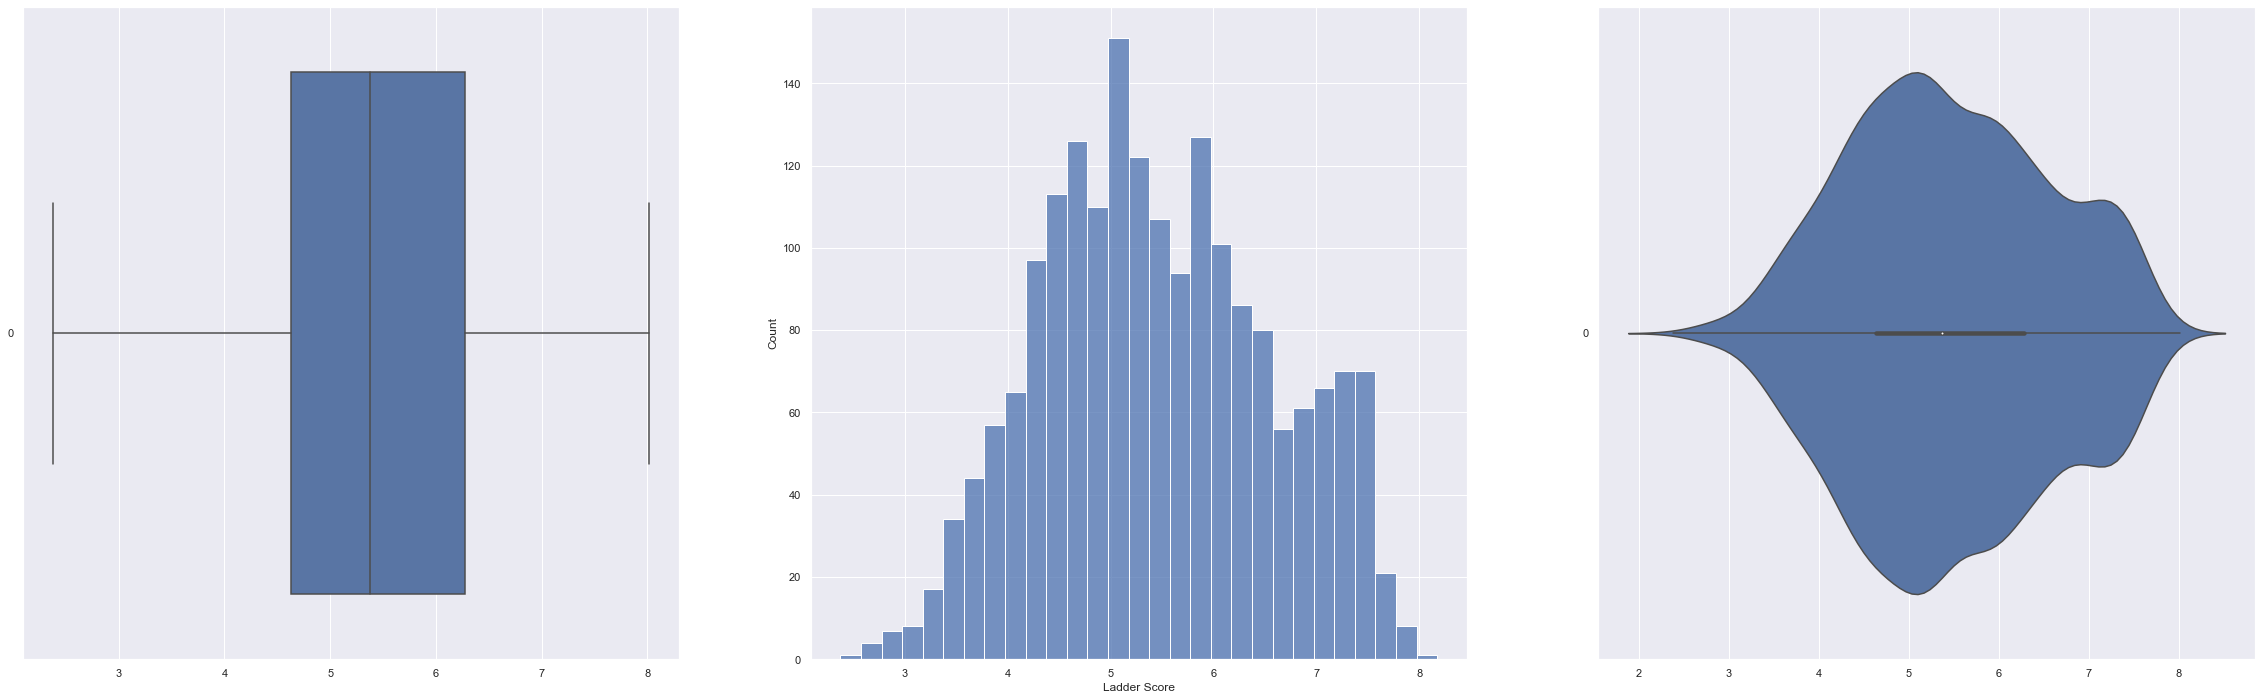

In [14]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["Ladder Score"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['Ladder Score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["Ladder Score"], orient = "h", ax = axes[2])

Explore the predicor variable <mark>"CO2 Per Capita"</mark>.

<AxesSubplot:>

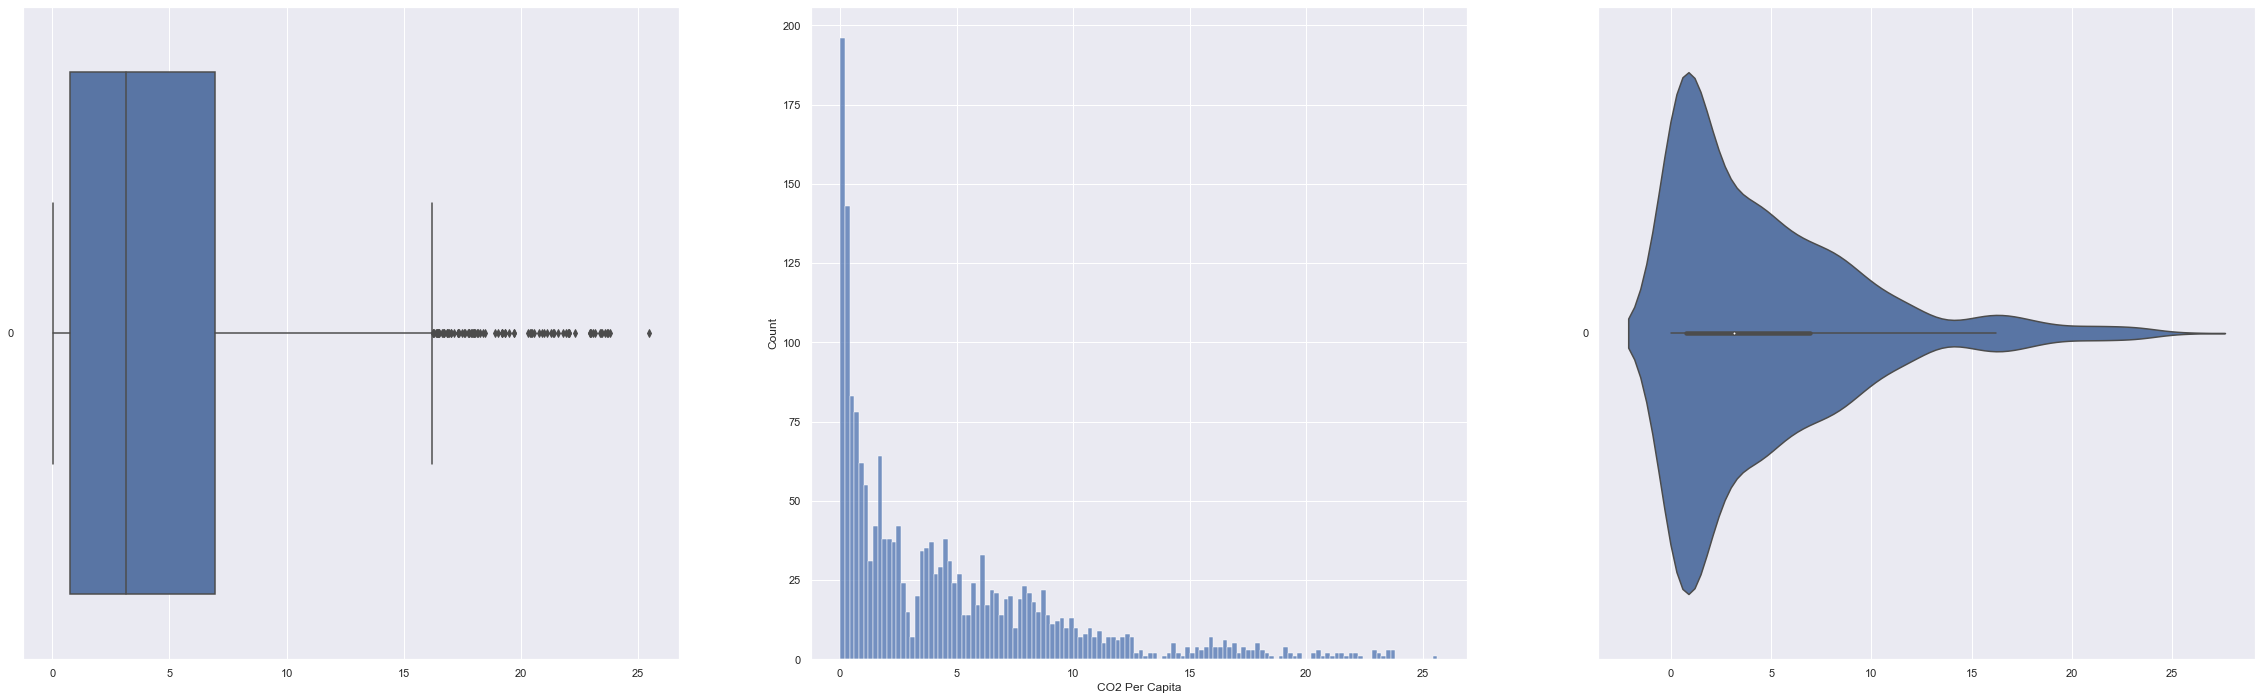

In [15]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["CO2 Per Capita"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['CO2 Per Capita'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["CO2 Per Capita"], orient = "h", ax = axes[2])

Find rows that are <mark>outliers</mark> and remove them

In [16]:
noMoreOutliers = True
while True:
  noMoreOutliers = True
  LadderScore_q3, LadderScore_q1 = np.percentile(dfCO2andHappiness["Ladder Score"], [75, 25])
  CO2PerCapita_q3, CO2PerCapita_q1 = np.percentile(dfCO2andHappiness["CO2 Per Capita"], [75, 25])
  LadderScore_iqr = LadderScore_q3 - LadderScore_q1
  CO2PerCapita_iqr = CO2PerCapita_q3 - CO2PerCapita_q1
  deleteRow = False
  countries_to_remove = []
  for index, row in dfCO2andHappiness.iterrows():
      deleteRow = False
      if (row["Ladder Score"] <= LadderScore_q1 - 1.5*LadderScore_iqr) or (row["Ladder Score"] >= LadderScore_q3 + 1.5*LadderScore_iqr):
          deleteRow = True
      if (row["CO2 Per Capita"] <= CO2PerCapita_q1 - 1.5*CO2PerCapita_iqr) or (row["CO2 Per Capita"] >= CO2PerCapita_q3 + 1.5*CO2PerCapita_iqr):
          deleteRow = True
      if deleteRow == True:
          noMoreOutliers = False
          countries_to_remove.append(index)
  for country in countries_to_remove:
      dfCO2andHappiness.drop(index = country, inplace = True)
  if noMoreOutliers:
    break

Explore the response variable <mark>"Ladder score"</mark>.

<AxesSubplot:>

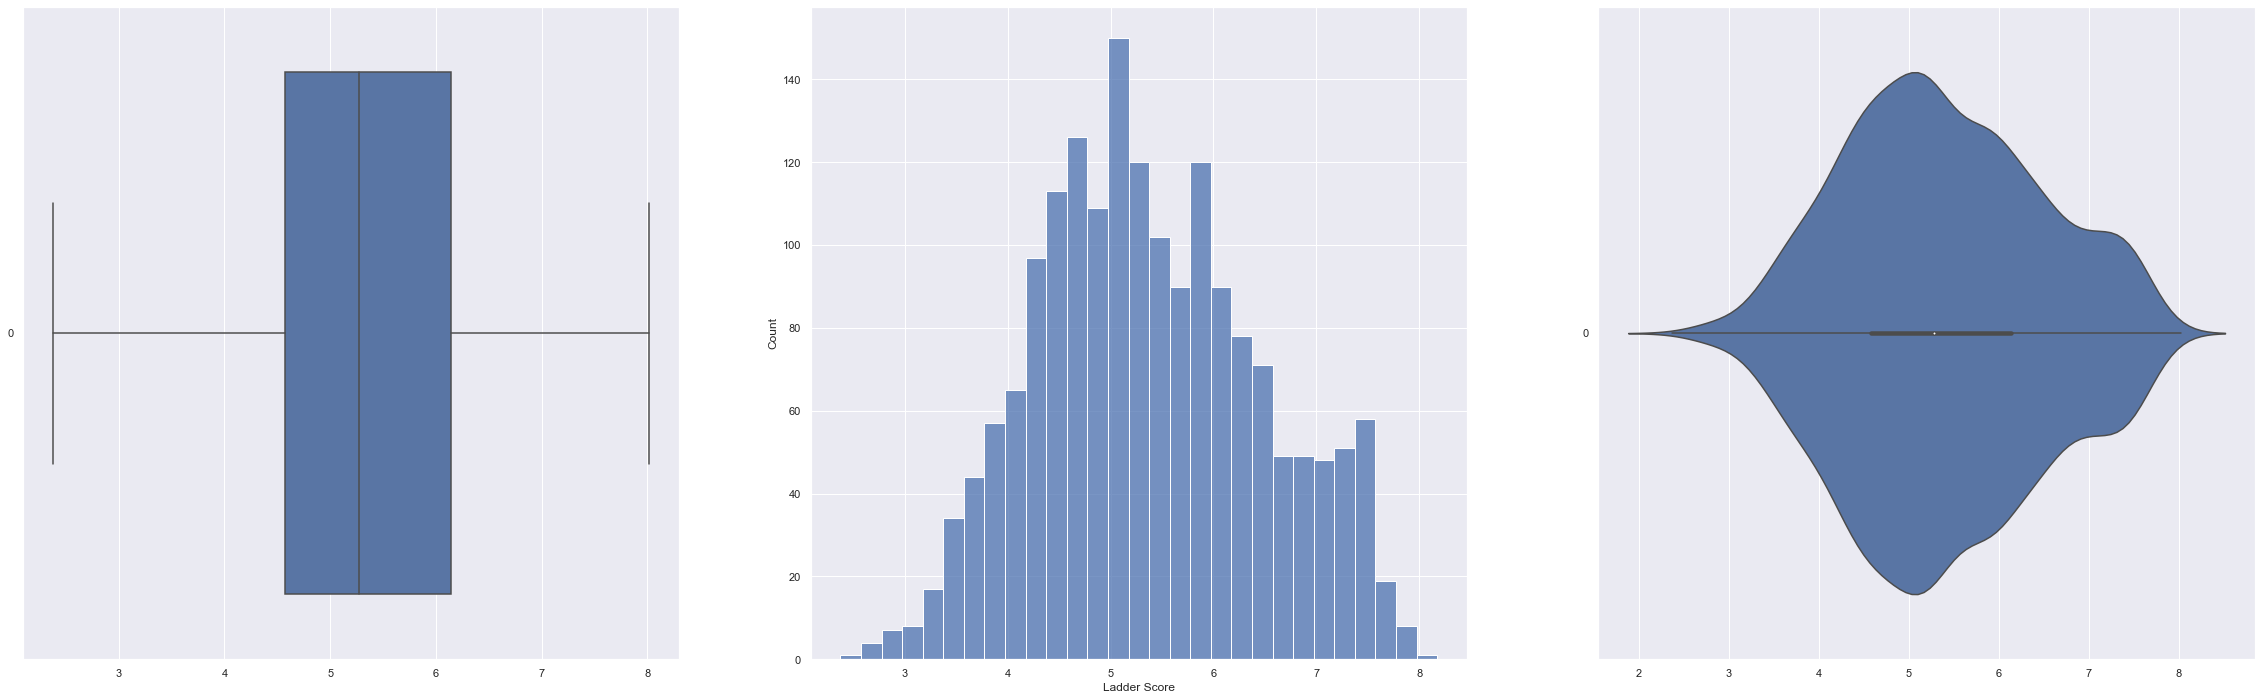

In [17]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["Ladder Score"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['Ladder Score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["Ladder Score"], orient = "h", ax = axes[2])

Explore the response variable <mark>"CO2 Per Capita"</mark>.



<AxesSubplot:>

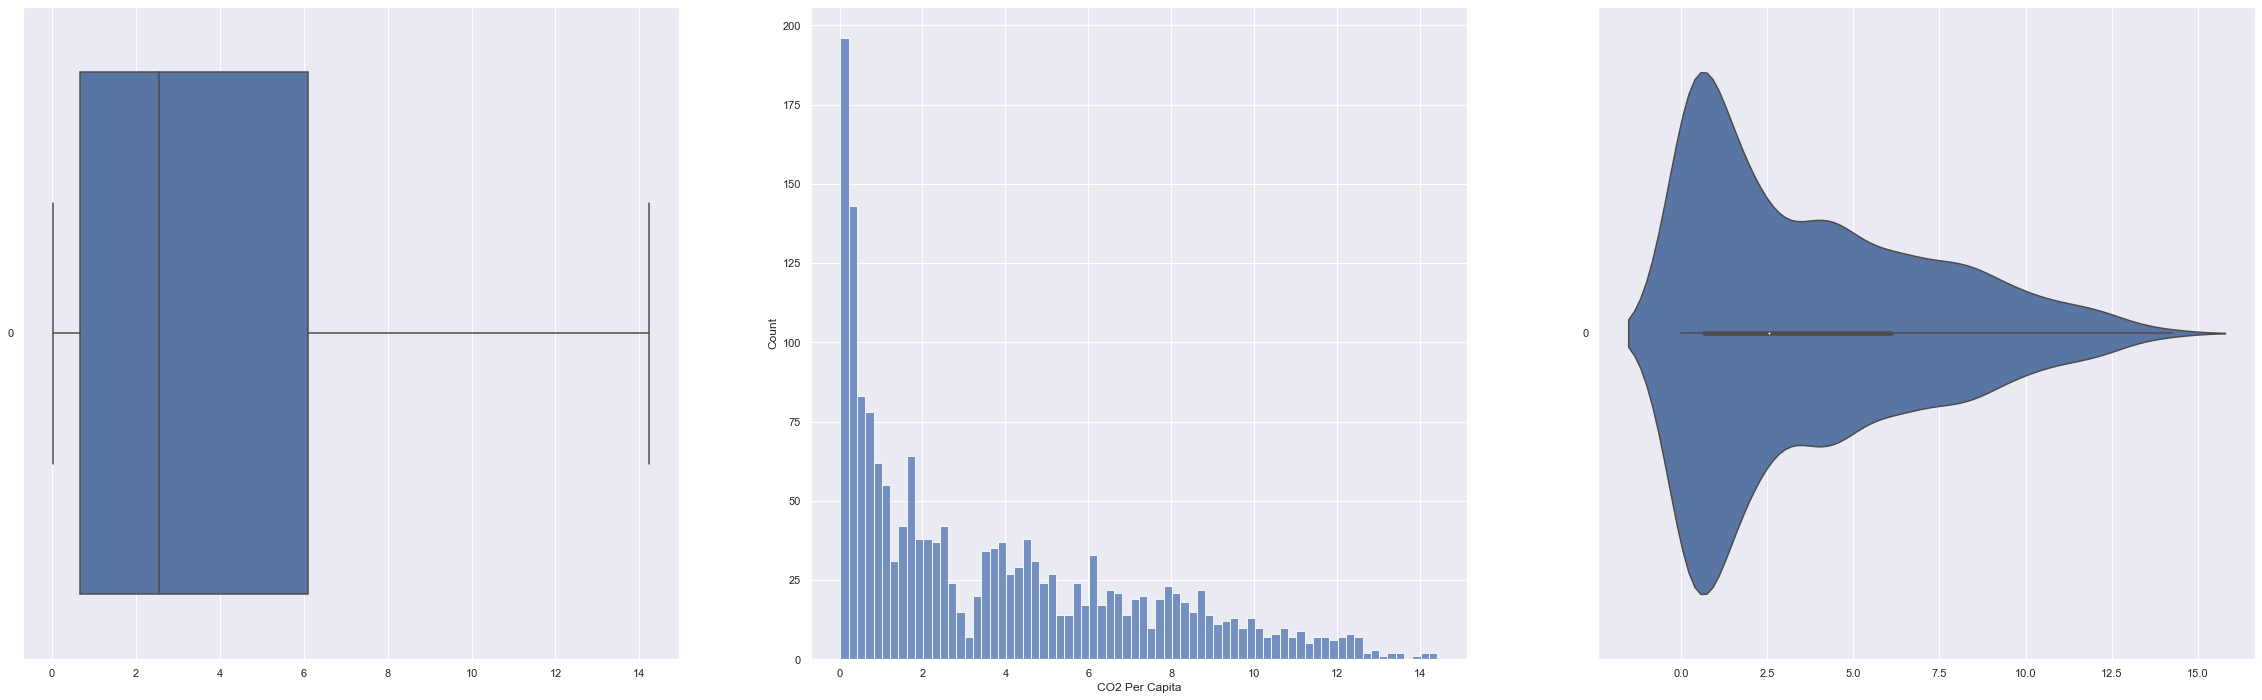

In [18]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = dfCO2andHappiness["CO2 Per Capita"], orient = "h", ax = axes[0])
sb.histplot(data = dfCO2andHappiness['CO2 Per Capita'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = dfCO2andHappiness["CO2 Per Capita"], orient = "h", ax = axes[2])

<mark>dfCO2andHappiness</mark> is now outlier free


Joinplot of <mark>"Ladder Score"</mark> against <mark>"CO2 Per Capita"</mark>

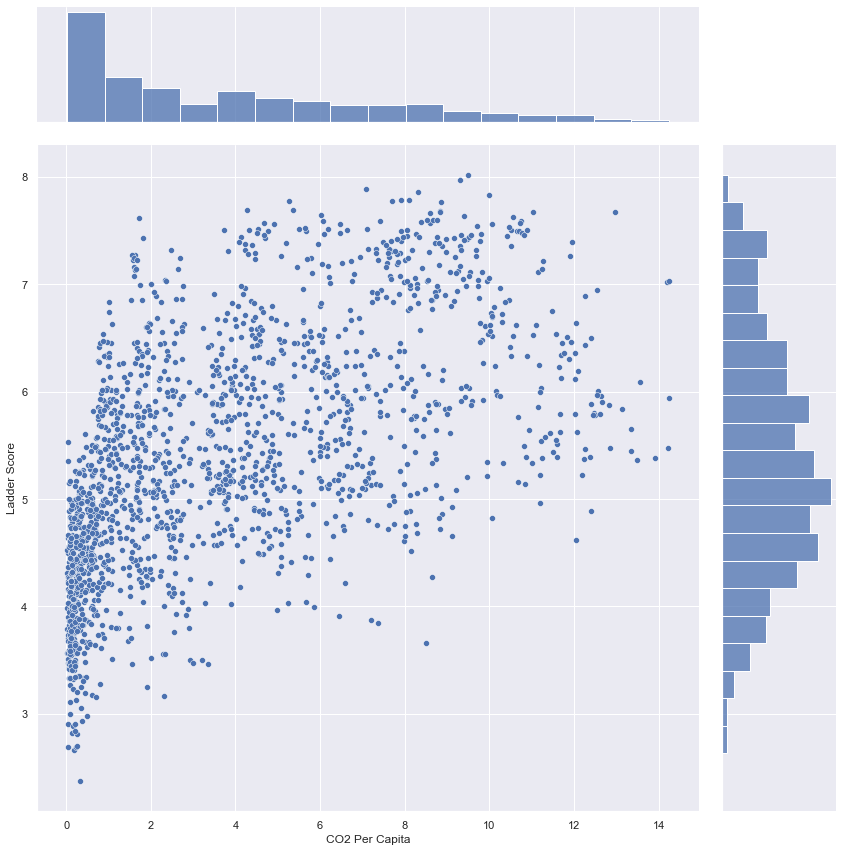

In [19]:
sb.jointplot(data = dfCO2andHappiness, x = "CO2 Per Capita", y = "Ladder Score", height = 12)

Calculate the <mark>correlation</mark> between the two variables

<AxesSubplot:>

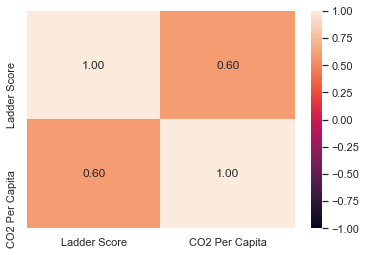

In [20]:
sb.heatmap(dfCO2andHappiness.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Train Set : (1428, 1) (1428, 1)
Test Set  : (358, 1) (358, 1)
Intercept of Regression 	: b =  [-6.4923524]
Coefficients of Regression 	: a =  [[1.89403632]]



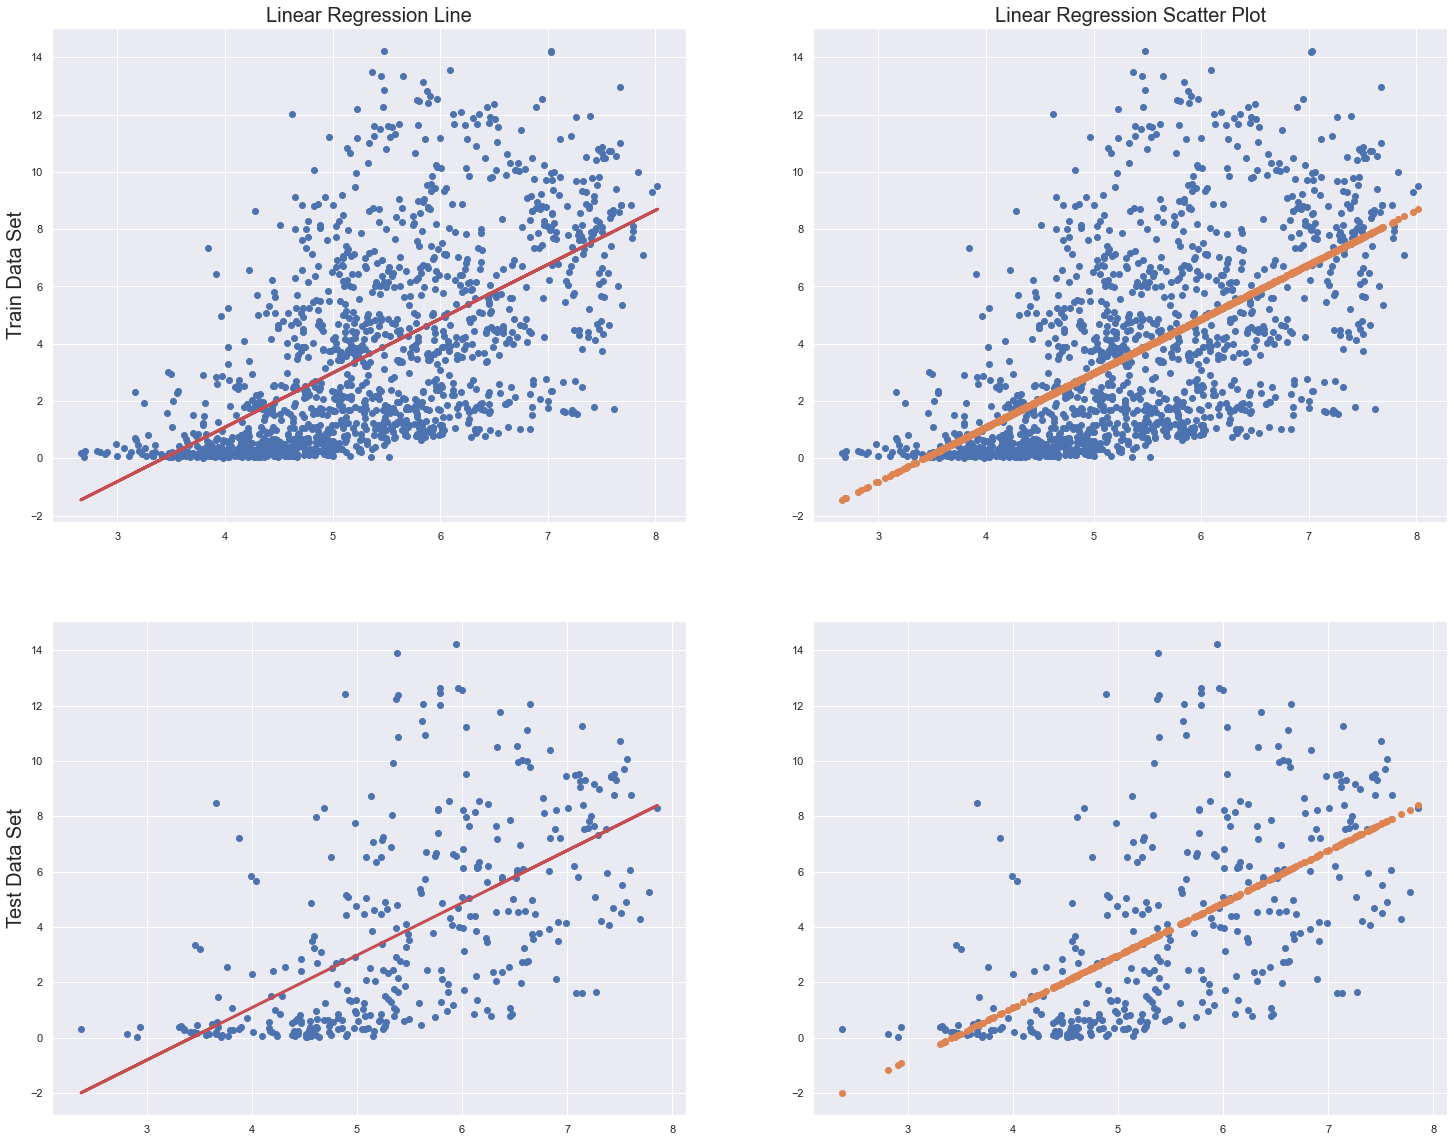

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.36348278678901136
Mean Squared Error (MSE) 	: 7.416129520338604
Root Mean Squared Error (RMSE) 	: 2.7232571528114278

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.33744559029581
Mean Squared Error (MSE) 	: 8.537032399559173
Root Mean Squared Error (RMSE) 	: 2.9218200491404622


The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.


In [21]:
traindf = dfCO2andHappiness.dropna()
gla = pd.DataFrame(traindf['Ladder Score']) 
sp = pd.DataFrame(traindf['CO2 Per Capita']) 
sp.head()

X_train, X_test, y_train, y_test = train_test_split(gla, sp, test_size = 0.2, shuffle = True)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model




# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Assign X-train data into regine_x
regline_x = X_train

# FOR TRAINED DATA SET
# !! For LINE GRAPH
regline_y = linreg.coef_ * X_train + linreg.intercept_
f, axes = plt.subplots(2, 2, figsize=(25, 20))
axes[0,0].scatter(X_train, y_train)
axes[0,0].plot(regline_x, regline_y, 'r-', linewidth = 3)
axes[0,0].set_title("Linear Regression Line", fontsize=20)
axes[0,0].set_ylabel("Train Data Set", fontsize=20)

# !! For PREDICTED SCATTER LINE
y_train_pred = linreg.predict(X_train)
axes[0,1].scatter(X_train, y_train)
axes[0,1].scatter(X_train, y_train_pred)
axes[0,1].set_title("Linear Regression Scatter Plot", fontsize=20)

## FOR TEST DATA SET
regline_xtest = X_test
y_test_pred = linreg.predict(X_test)

axes[1,0].scatter(X_test, y_test)
axes[1,0].plot(regline_xtest, y_test_pred, 'r-', linewidth = 3)
axes[1,0].set_ylabel("Test Data Set", fontsize=20)

axes[1,1].scatter(X_test, y_test)
axes[1,1].scatter(regline_xtest, y_test_pred)
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_train, y_train_pred, squared = False))

print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_test, y_test_pred, squared = False))

print()

print("""
The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.""")


GoodnessTrain1 = linreg.score(X_train, y_train)
AccuracyTrain1 = mean_squared_error(y_train, y_train_pred, squared = False)
GoodnessTest1 = linreg.score(X_test, y_test)
AccuracyTest1 = mean_squared_error(y_test, y_test_pred, squared = False)